In [2]:
import pandas as pd
import numpy as np
import torch
import os
import random
import easydict

import torch
import torch.nn as nn

from fusion_methods import AutoFusion
from DataLoader import *
from Functionals import *
from Learn import *
from Models import *




from Save import *
from Utils import *

/home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Init

In [3]:
seed = 20240321

random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # type: ignore
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = False  # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = easydict.EasyDict({
    'bus_id': 'PCI_BUS_ID',
    'cuda_id': ['0', '1', '2'],

    # args for path

    'senior_dir_path': './audio_text_features.csv',
    'structure_save_path': './save/figures/structure/',
    'model_save_path':'./save/model/',
    'tensor_save_path':'./save/tensor/',
    # args for counts
    'n_subjects': 24,
    'n_audio_features': 88,
    'n_text_features': 768,
    'n_features': 856,
    'n_samples': 1512,
    'n_labels_by_class':151,

    # args for running algorithm
    'seed': 20240321,
    
    'de_k': 215,
    'k1': 9,
    't1': 1,
    
    'gcn_hid_channels': 256,
    'gcn_out_channels': 128,
    'proj_hid_channels': 32,
    'out_channels': 7,
    'learning_rate': 0.005,
    'weight_decay':0.0001,
    'loss_coefficient': 0.01,
    'epochs': 3000,

    'ptau': 0.7,
    'pf1': 0.2,
    'pf2': 0.3,
    'pe1': 0.2,
    'pe2': 0.3,
    'tpf1': 0.7,
    'tpf2': 0.7,
    'tpe1': 0.7,
    'tpe2': 0.7,
    'patience': 10
})


In [4]:
device

device(type='cuda')

# Load data

In [5]:
data = pd.read_csv('audio_text_features.csv')

label = torch.from_numpy(data['Label'].to_numpy()).to(torch.long)
audio = torch.from_numpy(data.loc[:,'audio_feature1':'audio_feature88'].to_numpy()).to(torch.float32)
text = torch.from_numpy(data.loc[:, 'text_feature1':].to_numpy()).to(torch.float32)
print(label.shape, label.dtype)
print(audio.shape, audio.dtype)
print(text.shape, text.dtype)

torch.Size([1512]) torch.int64
torch.Size([1512, 88]) torch.float32
torch.Size([1512, 768]) torch.float32


In [6]:
data

,file,Label,audio_length,audio_feature1,audio_feature2,audio_feature3,audio_feature4,audio_feature5,audio_feature6,audio_feature7,...,text_feature759,text_feature760,text_feature761,text_feature762,text_feature763,text_feature764,text_feature765,text_feature766,text_feature767,text_feature768
0,Sub01_a1,0,6.500000,28.788942,0.309829,13.366469,32.531185,35.282223,21.915752,122.668430,...,0.070970,0.256422,0.249997,-0.025562,-0.074572,-0.405840,0.155058,-0.132768,-0.237525,-0.156939
1,Sub01_a2,0,8.083333,28.920060,0.271033,24.236807,32.112198,33.583893,9.347086,150.552470,...,-0.097131,0.124895,0.167208,0.020567,-0.231155,-0.359346,-0.087718,-0.121685,-0.312636,0.202202
2,Sub01_a3,0,4.916667,27.654469,0.296198,13.141718,31.445354,33.059586,19.917868,34.554985,...,0.073111,0.202676,0.173619,-0.027530,-0.074597,-0.433110,0.022197,-0.181147,-0.149919,-0.043900
3,Sub01_a4,0,5.250000,29.085270,0.253985,25.799112,32.057404,33.584910,7.785799,380.644300,...,0.039497,0.163971,0.306387,0.043279,-0.554354,-0.405674,-0.064010,-0.206992,-0.271196,-0.152854
4,Sub01_a5,0,8.125000,28.662527,0.272022,22.840014,31.862585,33.586594,10.746580,195.374130,...,0.033405,0.198363,0.300925,-0.043898,-0.036387,-0.409670,0.072677,-0.098308,-0.198373,-0.092416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,Sub30_g5,6,10.466667,20.274664,0.257152,13.316469,22.382391,24.655754,11.339285,122.531510,...,-0.003371,0.272633,0.204179,-0.109836,-0.067147,-0.456037,-0.013331,-0.125618,-0.202032,-0.128672
1508,Sub30_g6,6,8.733333,19.639650,0.285645,12.824641,22.285406,24.579088,11.754447,210.436450,...,0.116483,0.257295,0.181340,-0.079939,-0.210461,-0.480470,0.058964,-0.094436,-0.154361,-0.289280
1509,Sub30_g7,6,8.800000,19.295887,0.298035,12.951897,21.393229,24.657038,11.705141,131.742230,...,-0.072002,0.154574,0.283339,-0.073323,-0.191571,-0.395051,0.098819,-0.349565,-0.088541,-0.358817
1510,Sub30_g8,6,10.733333,19.129637,0.280693,12.905231,21.626654,24.222975,11.317744,182.370400,...,0.057107,0.120299,0.061530,-0.058706,-0.393576,-0.277797,0.018282,-0.296795,-0.098138,0.146109


In [7]:
audio = torch.zeros((args.n_samples, args.n_audio_features), dtype=torch.float32)
text = torch.zeros((args.n_samples, args.n_text_features), dtype=torch.float32)
label = torch.zeros((args.n_samples),dtype=torch.long)
cnt = 0
for i in range(1, 31):
    if i <10:
        sub_idx = f"Sub0{i}"
    else:
        sub_idx = f"Sub{i}"
    filtered_data = data[data['file'].str.contains(sub_idx)]
    
    if not filtered_data.empty:
        label[cnt*63:(cnt+1)*63] =  torch.from_numpy(filtered_data.loc[:,'Label'].to_numpy()).to(torch.long)
        audio[cnt*63:(cnt+1)*63] = torch.from_numpy(filtered_data.loc[:,'audio_feature1':'audio_feature88'].to_numpy()).to(torch.float32)
        text[cnt*63:(cnt+1)*63] = torch.from_numpy(filtered_data.loc[:,'text_feature1':].to_numpy()).to(torch.float32)
        cnt += 1


audio = torch.where(torch.isnan(audio), torch.zeros_like(audio), audio)
text = torch.where(torch.isnan(text), torch.zeros_like(text), text)
label = torch.where(torch.isnan(label), torch.zeros_like(label), label)

print(label)
print(audio)
print(text)
        
    

tensor([0, 0, 0,  ..., 6, 6, 6])
tensor([[ 2.8789e+01,  3.0983e-01,  1.3366e+01,  ...,  4.4444e-02,
          2.0608e-02, -2.7261e+01],
        [ 2.8920e+01,  2.7103e-01,  2.4237e+01,  ...,  5.2308e-02,
          4.5430e-02, -2.8365e+01],
        [ 2.7654e+01,  2.9620e-01,  1.3142e+01,  ...,  6.5000e-02,
          6.5765e-02, -2.9220e+01],
        ...,
        [ 1.9296e+01,  2.9804e-01,  1.2952e+01,  ...,  4.7143e-02,
          2.8140e-02, -3.2524e+01],
        [ 1.9130e+01,  2.8069e-01,  1.2905e+01,  ...,  4.4062e-02,
          2.9032e-02, -3.5714e+01],
        [ 1.9732e+01,  2.8654e-01,  1.2907e+01,  ...,  5.8077e-02,
          3.2108e-02, -3.4275e+01]])
tensor([[-0.0222, -0.1202,  0.4339,  ..., -0.1328, -0.2375, -0.1569],
        [-0.1919, -0.1110,  0.4024,  ..., -0.1217, -0.3126,  0.2022],
        [ 0.1220, -0.0955,  0.3898,  ..., -0.1811, -0.1499, -0.0439],
        ...,
        [ 0.2345, -0.1397,  0.5073,  ..., -0.3496, -0.0885, -0.3588],
        [ 0.0008, -0.2807,  0.4013,  ..., 

# train test split

========================================== Protocol 151 ==========================================


******************* TEST fold 3:1 / Fold 1 *********************

 similarity matrix construction start...

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1701 sec
Done
**********************************************

 similarity matrix construction Done...
directory already exists
confusion_matrix_fold_1 is saved successfully
*** Best ACC : 77.25 ***


******************* TEST fold 3:1 / Fold 2 *********************

 similarity matrix construction start...

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1664 sec
Done
***************************************

/home/neuroai/users/dhkim/MER_senior/Save/Figures.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(matrix)


directory already exists
confusion_matrix_fold_4 is saved successfully
*** Best ACC : 73.81 ***

**************** Best and Average acc of 24 folds bysubject *********************
** Best ACC : [77.25, 69.58, 73.81, 73.81] **
 ** Avearge acc : 73.61,    std : 2.72 **


 Best Epochs : [353, 450, 263, 287]
directory already exists
protocol_151_best_acc_list_240321 is saved successfully


<Figure size 640x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

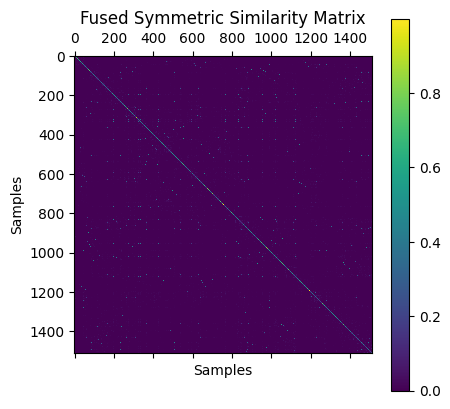

In [9]:
n_labels_by_class = args.n_labels_by_class

best_epoch_list = []
best_acc_list = []
orig_acc_list = []

im = torch.eye(args.n_samples, dtype=torch.float32)
print("========================================== Protocol {} ==========================================".format(int(n_labels_by_class)))

for i in range(4):
    
    print("\n\n******************* TEST fold 3:1 / Fold {} *********************".format(i+1))
    sub_idx = 'fold_'+str(i+1)
    date = '240321'
    
    # axis 1 is layer norm
    audio = normalization(audio, axis = 0, ntype='standardization')
    text = normalization(text, axis=0, ntype='standardization')

    print("\n similarity matrix construction start...")
    asm = similarity_matrix(audio, scale = 0.9)
    sasm = (asm+asm.T)/2
    nsasm = symmetric_normalization(sasm,im)
    
    tsm = similarity_matrix(text, scale=0.9)
    stsm = (tsm+tsm.T)/2
    nstsm = symmetric_normalization(stsm,im)
    
    fsm = ssm_fusion(asm,nsasm,tsm,nstsm,args.k1, args.t1)
    print("\n similarity matrix construction Done...")
    
    save_heatmap(asm, "Audio Similarity Matrix", "Samples", "Samples", args.structure_save_path+'asm_'+sub_idx+'_'+date+'.png', clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
    save_heatmap(nsasm, "Normalized Symmetric Audio Similarity Matrix", "Samples", "Samples", args.structure_save_path+'nsasm_'+sub_idx+'_'+date+'.png', clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
    save_heatmap(tsm, "Text Similarity Matrix", "Samples", "Samples", args.structure_save_path+'tsm_'+sub_idx+'_'+date+'.png', clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
    save_heatmap(nstsm, "Normalized Symmetric Text Similarity Matrix", "Samples", "Samples", args.structure_save_path+'nstsm_'+sub_idx+'_'+date+'.png', clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

    save_heatmap(fsm, "Fused Symmetric Similarity Matrix", "Samples", "Samples", args.structure_save_path+'/fsm_'+sub_idx+'_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
    

    adj = fsm.to(device)
    feature = concatenate_fusion(audio,text).to(device)
    label = label.to(device)
    
    #                 save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 
    
    identifier = torch.ones(args.n_samples, 1).bool()
    # Later fix code - test subjects need to be randomly selected 
    identifier[i*63*6:(i+1)*63*6]=False
    train_identifier = identifier.squeeze().to(device)
    test_identifier = ~train_identifier
    
    activation = get_activation('celu')
    gcn = GraphConvolution

    encoder = GraphConvolutionalEncoder(args.n_features, args.gcn_hid_channels, args.gcn_out_channels, activation, base_model = gcn).to(device)
    model = GRACE(encoder, args.n_features, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate, weight_decay=args.weight_decay)
    
    best_acc, best_epoch, best_z, result, cfm = GCA_train(model, optimizer, feature, adj, label,
                                                                        train_identifier, test_identifier,
                                                                        args,device, isdeap=False, verbose=False)
    
    experiment_type = 'subject_independent'
    model_save_name = sub_idx+'_model'
    model_path = args.model_save_path+experiment_type+'_'+date+'_'+model_save_name
    torch.save(model.state_dict(), model_path)
    
    save_np(args.tensor_save_path,'confusion_matrix_'+sub_idx, cfm)
    
    print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
    best_epoch_list.append(best_epoch)
    best_acc_list.append(round(best_acc.item(), 2))
    orig_acc_list.append(best_acc.item())
    
    
    # sample = best_z.cpu().detach().numpy().copy()
    #     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
    #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
    #     dr_result = drmodel.fit_transform(tsne_sample)
    #     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    # if p == 0:    
    #     save_np(arggs.tensor_save_path+'ablation3/'+sub_idx,'input_feature', feature)
    #     save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'DE_PSD_SNF_GCL', sample)
    
print("\n**************** Best and Average acc of 24 folds bysubject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

print("\n Best Epochs : {}".format(best_epoch_list))
best_acc_list = np.array(best_acc_list)
orig_acc_list = np.array(orig_acc_list)
save_np(args.tensor_save_path,'protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, orig_acc_list)


In [12]:
print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
best_epoch_list.append(best_epoch)
best_acc_list.append(round(best_acc.item(), 2))
orig_acc_list.append(best_acc.item())


# sample = best_z.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
# if p == 0:    
#     save_np(arggs.tensor_save_path+'ablation3/'+sub_idx,'input_feature', feature)
#     save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'DE_PSD_SNF_GCL', sample)

print("\n**************** Best and Average acc of 24 folds by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

print("\n Best Epochs : {}".format(best_epoch_list))
best_acc_list = np.array(best_acc_list)
orig_acc_list = np.array(orig_acc_list)
save_np(args.tensor_save_path,'protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, orig_acc_list)

*** Best ACC : 80.95 ***

**************** Best and Average acc of 24 folds by subject *********************
** Best ACC : [80.95] **
 ** Avearge acc : 80.95,    std : 0.0 **


 Best Epochs : [130]
directory already exists
protocol_151_best_acc_list_240321 is saved successfully


In [10]:
  save_np(args.tensor_save_path,'confusion_matrix_'+sub_idx, cfm)

directory already exists
confusion_matrix_sub_1 is saved successfully


In [ ]:
n_samples = len(label)
n_classes = 7
n_labels_by_class = 151
labeled_data_identifier = torch.zeros(n_samples, dtype=torch.bool)
for i in range(n_classes):
    indices = (label == i).nonzero(as_tuple=True)[0]
    labeled_idx = random.sample(indices.tolist(), n_labels_by_class)
    labeled_data_identifier[labeled_idx] = True

print(labeled_data_identifier.nonzero(as_tuple=True)[0].shape)

In [ ]:
subject_de, _, subject_label = load_subject_data(args)


visualization_type = 1

n_labels_by_class = args.n_labels_by_class

best_epoch_list = []
best_acc_list = []
orig_acc_list = []
print("========================================== Protocol {} ==========================================".format(int(n_labels_by_class)))

print("\n\n******************* SUBJECT : {} *********************".format(i+1))
sub_idx = 'sub_all'
date = '240321'

sub_de = subject_de[i]
#         sub_psd = subject_psd[i]
sub_label = subject_label[i]
#         sub_sample_counts = subject_sample_counts[i]

de = flatten(sub_de, args.n_nodes*args.n_features)
identifier = generate_identifiers(sub_label, n_labels_by_class, args.out_channels, args.seed,
                isdeap=False)


de = normalization(de, axis = 0, ntype='standardization')
#         psd = normalization(psd, axis = 0, ntype='standardization')

#                 de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
#                 psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)

print("\nDistance matrix construction start...")
de_dm = distance_matrix(de)
#         psd_dm = distance_matrix(psd)
print("\nDistance matrix construction Done...")

de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)
#         psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
#         psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)


#                 save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
#                 save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

#         fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
#                 save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
#                 save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

#         adj = fsm
#                 save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
#                 save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

#         feature = input_feature(de, psd)

adj = de_ssm
feature = de
label = sub_label

#                 save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

feature = torch.from_numpy(feature).to(torch.float32).to(device)
adj = torch.from_numpy(adj).to(torch.float32).to(device)
label = torch.from_numpy(label).to(torch.long).to(device)

identifier = torch.from_numpy(identifier).bool()
train_identifier = identifier.to(device)
isunlabeled = ~identifier

test_identifier = isunlabeled.to(device)

activation = get_activation('celu')
gcn = GraphConvolution

encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)


best_acc, best_epoch, best_z, result, cfm = GCA_train(model, optimizer, feature, adj, label,
                                                                    train_identifier, test_identifier,
                                                                    args,device, isdeap=False, verbose=True)

#                 experiment_type = 'subject_dependent'
#                 model_save_name = sub_idx+'_model'
#                 model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
#                 torch.save(model.state_dict(), model_path)

save_np(args.tensor_save_path+'main/confusion_matrix/'+sub_idx,'protocol_'+str(n_labels_by_class)+'_confusion_matrix', cfm)

print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
best_epoch_list.append(best_epoch)
best_acc_list.append(round(best_acc.item(), 2))
orig_acc_list.append(best_acc.item())



sample = best_z.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
if p == 0:    
    save_np(arggs.tensor_save_path+'ablation3/'+sub_idx,'input_feature', feature)
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'DE_PSD_SNF_GCL', sample)

print("\n**************** Best acc by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

print("\n Best Epochs : {}".format(best_epoch_list))
best_acc_list = np.array(best_acc_list)
orig_acc_list = np.array(orig_acc_list)
save_np(args.tensor_save_path+'main/', 'protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, orig_acc_list)

save_np(args.tensor_save_path+'ablation2/', 'DE_PSD_SNF_GCL_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, orig_acc_list)
